# [KerasCV] YOLOv8 Instance Segmentation

**Author:** [Usha Rengaraju](https://www.linkedin.com/in/usha-rengaraju-b570b7a2/)<br>
**Date created:** 2023/07/10<br>
**Last modified:** 2023/07/10<br>
**Description:** YOLOV8 Instance Segmentation using KerasCV

## Overview

Instance segmentation differs from the semantic segmentation in the way that  a unique form of image segmentation that deals with detecting and delineating each distinct instance of an object appearing in an image. Instance Segmentation is a very useful task in autonomous driving.

In this guide we show you how to use the `yolov8detector` backbone of KerasCV to perform the Instance segmentation task.

## Imports & setup

This tutorial requires you to have KerasCV installed:

```shell
pip install keras-cv
```

We begin by importing all required packages:

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from glob import glob
from scipy.io import loadmat
import keras_cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
%matplotlib inline

## Data loading

This guide uses the
[COCO 2017 dataset](https://cocodataset.org/#home)
for demonstration purposes.

To get started, we first download and unzip the dataset:

In [ ]:
!mkdir COCOdataset2017
!mkdir COCOdataset2017/images

In [ ]:
# !wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip

--2023-07-07 16:21:27--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.97.140, 16.182.66.225, 52.217.227.81, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.97.140|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  13.5MB/s    in 60s     

2023-07-07 16:22:27 (13.0 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [ ]:
!unzip -qq val2017.zip -d COCOdataset2017/images/
#rename folder from val2017 to val

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -qq /content/annotations_trainval2017.zip -d COCOdataset2017/

--2023-07-07 16:23:04--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.38.201, 52.217.68.76, 3.5.27.163, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.38.201|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  13.2MB/s    in 20s     

2023-07-07 16:23:24 (12.2 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



## Data Preprocessing

Next we preprocess the dataset starting with filtering out selected classes and then create the data generator for the model training

In [ ]:
def filterDataset(annFile, classes=None, mode='train'):
    coco = COCO(annFile)

    images = []
    if classes!=None:
        for className in classes:
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)

    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)

    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])

    random.shuffle(unique_images)
    dataset_size = len(unique_images)

    return unique_images, dataset_size, coco

In [ ]:
ann = '/content/COCOdataset2017/annotations/instances_val2017.json'
classes = ['person','car','cat','dog']
mode = 'val'

images, dataset_size, coco = filterDataset(ann, classes, mode)

loading annotations into memory...
Done (t=0.68s)
creating index...
index created!


In [ ]:
dataset_size

3103

In [ ]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img

def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    classlst = {}
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        if className in classlst.keys():
          pixel_value = classes.index(className)+1+4*classlst[className]
          classlst[className]+=1
        else:
          classlst[className]=1
          pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        # train_mask = np.maximum(new_mask, train_mask)
        train_mask+=(train_mask==0)*new_mask

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask

def dataGeneratorCoco(images, classes, coco, folder,
                      input_image_size=(224,224), batch_size=4, mode='train', mask_type='binary'):

    img_folder = '{}/images/{}'.format(folder, mode)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            train_img = getImage(imageObj, img_folder, input_image_size)
            train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)

            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask

        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

In [ ]:
batch_size = 4
input_image_size = (512,512)
mask_type = 'normal'
mode = 'val'
folder = '/content/COCOdataset2017'
val_gen = dataGeneratorCoco(images, classes, coco, folder,
                            input_image_size, batch_size, mode, mask_type)

## Data Visualisation

Next we visualise the data generator created, we can clearly see the the different instances being shown in the generated image masks.

In [ ]:
def visualizeGenerator(gen):
    img, mask = next(gen)

    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)

    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])

            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

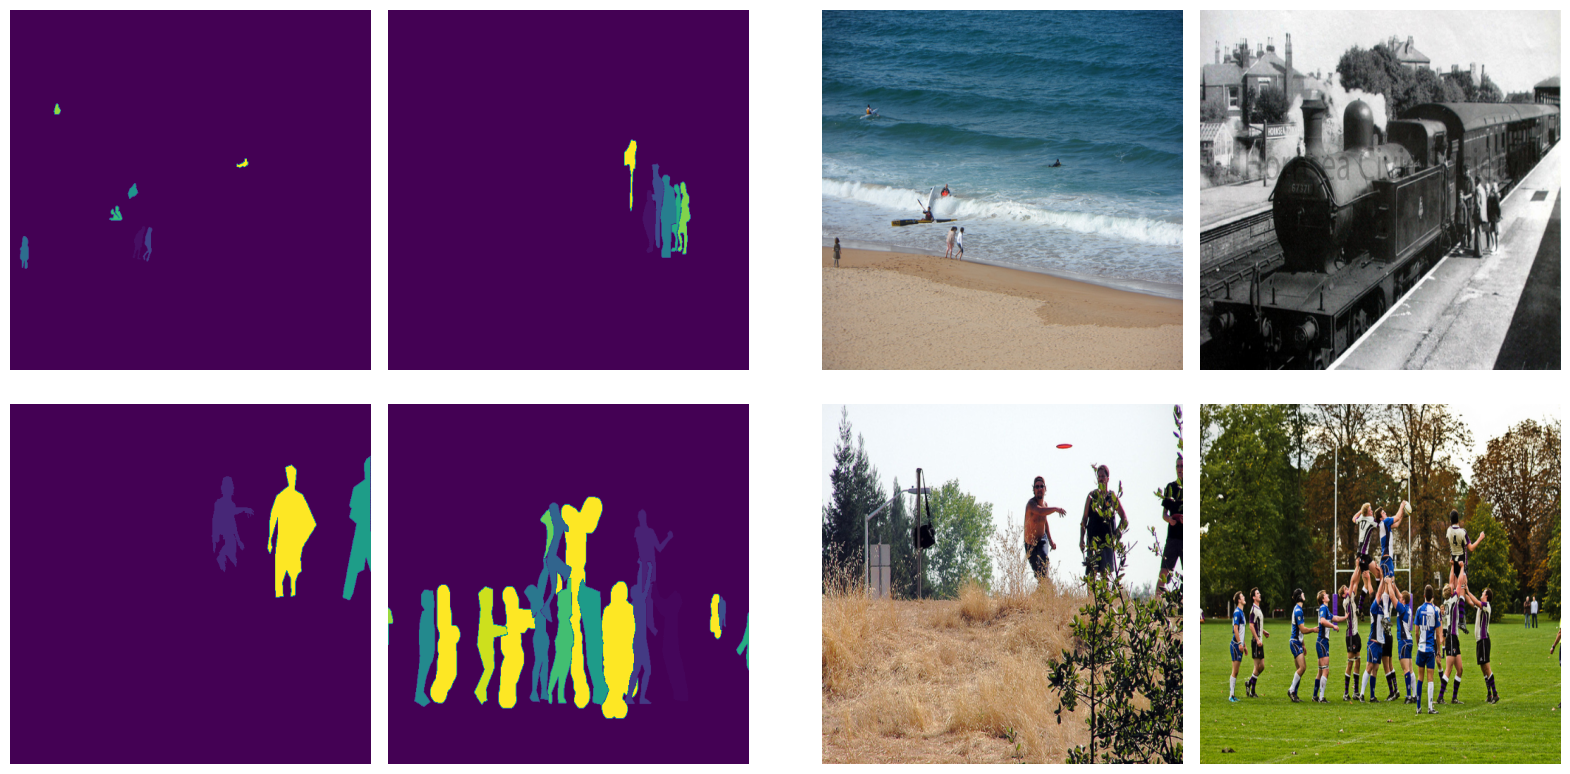

In [ ]:
visualizeGenerator(val_gen)

In [ ]:
from tqdm import tqdm
img_folder = '{}/images/{}'.format(folder, mode)
train_images=[]
train_masks = []
dataset_size = len(images)
catIds = coco.getCatIds(catNms=classes)
for i in tqdm(range(300)):
  imageObj = images[i]
  train_img = getImage(imageObj, img_folder, input_image_size)
  train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)
  train_images.append(train_img)
  train_masks.append(train_mask)



100%|██████████| 300/300 [00:08<00:00, 33.74it/s]


In [ ]:
np.max(train_masks)

53.0

## Model Building

Next we move on to the model building stage. We create a Unet model with skip connections. For the encoder part we use the `Yolov8detector` model and Conv2dTranspose based structure for the decoder part.

In [ ]:
backbone = keras_cv.models.YOLOV8Backbone(
    input_shape = (512,512,3),
    stackwise_channels=[ 128, 256],
    stackwise_depth=[ 1, 1],
    include_rescaling=False,
)

inp = backbone.input
x = backbone.output
x= Activation("relu")(x)
x = Conv2DTranspose(128,2,2)(x)
conc = backbone.get_layer('stack1_c2f_output_conv').output
x = Concatenate()([x, conc])
x= tf.concat([conc,x],3)
x = Conv2DTranspose(128,3,padding='same')(x)
conc = backbone.get_layer('stack1_c2f_pre_conv').output
x= tf.concat([x,conc],3)
x = Conv2DTranspose(64,2,2)(x)
conc = backbone.get_layer('stem_1_conv').output
x= tf.concat([x,conc],3)

x = UpSampling2D(2, interpolation='bicubic')(x)
x = Conv2D(55,1,padding='same')(x)
model = keras.Model(inputs=inp,outputs=x)

In [ ]:
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_55 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_1_pad (ZeroPadding2D)     (None, 514, 514, 3)  0           ['input_55[0][0]']               
                                                                                                  
 stem_1_conv (Conv2D)           (None, 256, 256, 64  1728        ['stem_1_pad[0][0]']             
                                )                                                                 
                                                                                           

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=10e-5),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(np.array(train_images),np.array(train_masks),batch_size = 4,verbose=1, epochs=5)

Epoch 1/5
75/75 [==============================] - 243s 3s/step - loss: 1.4671 - accuracy: 0.7664
Epoch 2/5
75/75 [==============================] - 217s 3s/step - loss: 0.8652 - accuracy: 0.8133
Epoch 3/5
75/75 [==============================] - 216s 3s/step - loss: 0.8206 - accuracy: 0.8137
Epoch 4/5
75/75 [==============================] - 220s 3s/step - loss: 0.7692 - accuracy: 0.8160
Epoch 5/5
75/75 [==============================] - 217s 3s/step - loss: 0.7626 - accuracy: 0.8170


In [ ]:
pred = model.predict(np.expand_dims(train_images[4],axis=0))
pred.shape

1/1 [==============================] - 0s 159ms/step


(1, 512, 512, 55)

In [ ]:
pred_m = np.sum(pred[0],axis=2)
pred_m.shape

(512, 512)

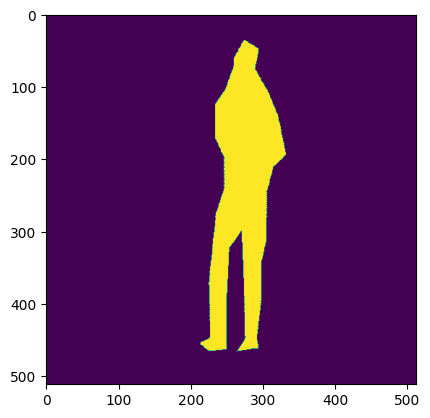

In [ ]:
plt.imshow(train_masks[4])

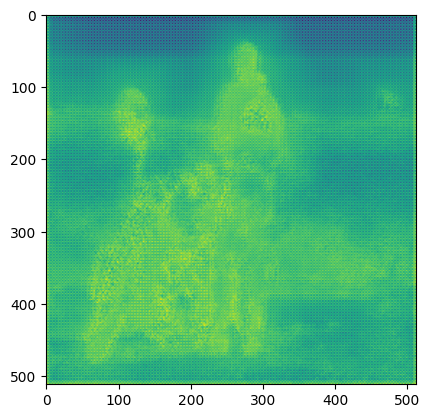

In [ ]:
plt.imshow(pred_m)